# Time-Series Generative Adversarial Networks on BATADAL Dataset
- Code: with a review of source code from the original [TimeGANs](https://github.com/jsyoon0823/TimeGAN), and others [1](https://towardsdatascience.com/modeling-and-generating-time-series-data-using-timegan-29c00804f54d), [2](https://towardsdatascience.com/synthetic-time-series-data-a-gan-approach-869a984f2239), [3](https://github.com/stefan-jansen/machine-learning-for-trading).
- Tool: Tensorflow 2.0
- Dataset: [BADATAL](https://www.batadal.net/data.html) dataset. This is a multivariate time-series dataset of a simulated cyber-physical system water distribution system.
- [Paper](https://papers.nips.cc/paper/2019/hash/c9efe5f26cd17ba6216bbe2a7d26d490-Abstract.html): "Time-series Generative Adversarial Networks" by Yoon et.al. NeurIPS 2019.

## About
- TimeGAN is chosen for this task since it can learn the temporal dynamic of time-series data.
- In this notebook, we will implement the 24 time-step/window-size.

In [1]:
# Expand Jupyter Notebook view
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Basic imports
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn related imports
import sklearn
from sklearn.preprocessing import MinMaxScaler

# Tensorflow related imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

2022-05-01 23:15:37.282683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 23:15:37.282699: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# Set GPU/CPU
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print("Using CUDA")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("Using CPU")

Using CPU


2022-05-01 23:15:38.465480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 23:15:38.465502: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 23:15:38.465521: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


In [5]:
# Set Seaborn Mode
sns.set_style('white')

## 1. Set Experiment Path

In [6]:
results_path = Path('../../results')
if not results_path.exists():
    results_path.mkdir()

In [7]:
log_dir = results_path / f'experiment_{0:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

## 2. Input Data

Input data, plot, correlation analysis, normalize the time series, and split the time-series into batch of 24-row windows

### 2.1. Training Parameters

In [8]:
seq_len = 24     # number of selected row
n_seq = 26       # number of selected features
batch_size = 128 # number of element per batch

### 2.2. Data Preprocessing

The dataset is located outside of the github repository

In [9]:
!ls ../../../../../

data
NeurIPS-2019-time-series-generative-adversarial-networks-Paper.pdf
NIPS2019_TGAN_Supplementary.pdf
tsgans_cps


In [10]:
df = pd.read_csv("../../../../../data/batadal_dataset03.csv")

In [11]:
# Check data type of each column
df.dtypes

DATETIME     object
L_T1        float64
L_T2        float64
L_T3        float64
L_T4        float64
L_T5        float64
L_T6        float64
L_T7        float64
F_PU1       float64
S_PU1         int64
F_PU2       float64
S_PU2         int64
F_PU3         int64
S_PU3         int64
F_PU4       float64
S_PU4         int64
F_PU5         int64
S_PU5         int64
F_PU6       float64
S_PU6         int64
F_PU7       float64
S_PU7         int64
F_PU8       float64
S_PU8         int64
F_PU9         int64
S_PU9         int64
F_PU10      float64
S_PU10        int64
F_PU11      float64
S_PU11        int64
F_V2        float64
S_V2          int64
P_J280      float64
P_J269      float64
P_J300      float64
P_J256      float64
P_J289      float64
P_J415      float64
P_J302      float64
P_J306      float64
P_J307      float64
P_J317      float64
P_J14       float64
P_J422      float64
ATT_FLAG      int64
dtype: object

In [12]:
# Get only float values
df = df[['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
         'F_PU1', 'F_PU2', 'F_PU4', 'F_PU7', 'F_PU8', 'F_PU10',
         'F_V2',
         'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 
         'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']]

In [13]:
# Check the shape of the newly updated DataFrame
df.shape

(8761, 26)

In [14]:
# Print out selected features in the table
features = list(df.columns)
print(f"Attributes names: {features}")

Attributes names: ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'F_PU2', 'F_PU4', 'F_PU7', 'F_PU8', 'F_PU10', 'F_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']


### 2.3. Plot Attributes of Time Series
Plot all selected features of the dataset. We can see that the data is very noisy.

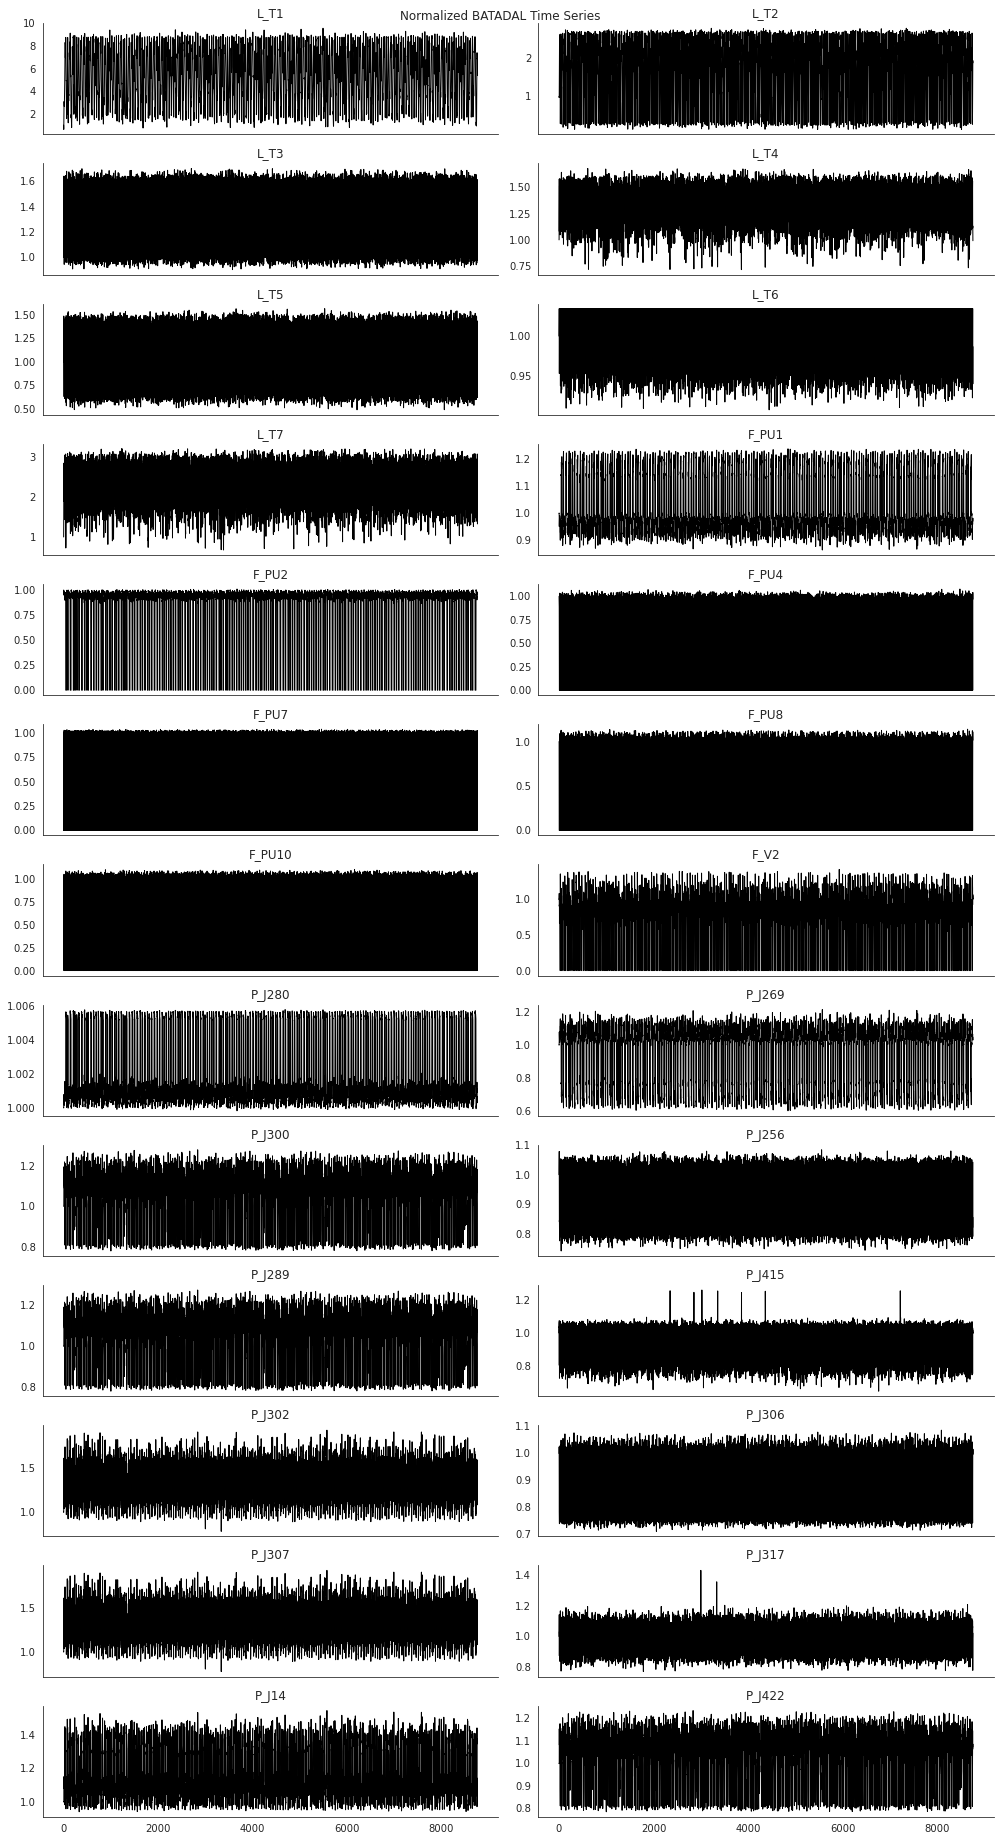

In [15]:
axes = df.div(df.iloc[0]).plot(subplots=True,
                              figsize=(14,26),
                              layout=(13,2),
                              title=features,
                              legend=False,
                              rot=0,
                              lw=1,
                              color='k')

for ax in axes.flatten():
    ax.set_xlabel("")
    
plt.suptitle("Normalized BATADAL Time Series")
plt.gcf().tight_layout()
sns.despine();

### 2.4. Correlationn between Attributes

We want to see the correlation between time-series. We know that the time-series data is temporal-dependence but in cyber-physical system, we also have spatio-dependence. This correlation allow us to check the spatial connection between them. This is very helpful in the case we want to check the temporal data should have the same correlation between selected features.

Populating the interactive namespace from numpy and matplotlib


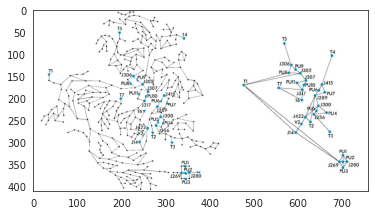

In [16]:
# Reference: "Cyber-Physical Attack Detection in Water Distribution Systems with Temporal Graph Convolutional Neural Networks" - Tsiami et al.
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('../../../../imgs/town_c.png')
imgplot = plt.imshow(img)
plt.show()

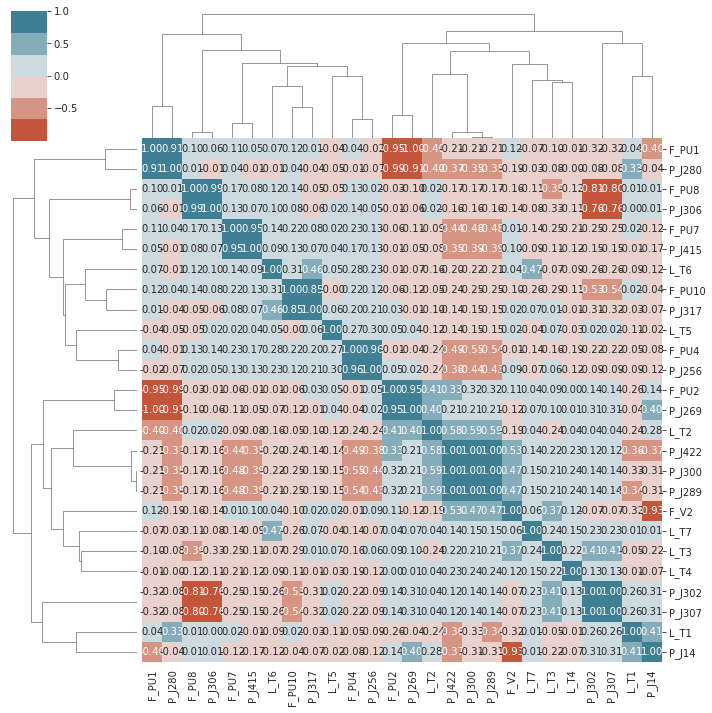

In [17]:
sns.clustermap(df.corr(),
              annot=True,
              fmt='0.2f',
              cmap=sns.diverging_palette(h_neg=20,
                                         h_pos=220), center=0)

### 2.5. Normalize Data

Scale each time series to the range [0, 1]. This will be helpful when we scale back to the synthetic dataset.

In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

### 2.6. Create Rolling Window Sequences

This will make the data from time series to IID by creating a rolling windows with overlapping sequences of 24 consecutive data point for each features.

In [19]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

In [20]:
np.asarray(data).shape

(8737, 24, 26)

## 3. Data Processing
We want to set up a generator to feed a Dataset that continues to call the random number generator as long as necessary and produce the desired batch size. We then shuffle the IID data.

In [21]:
real_series = (tf.data.Dataset
                .from_tensor_slices(data)
                .shuffle(buffer_size=n_windows)
                .batch(batch_size))

real_series_iter = iter(real_series.repeat())

2022-05-01 23:15:45.668629: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
def make_random_data():
    """Random generator at uniform distribution."""
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [23]:
random_series = iter(tf.data.Dataset
                        .from_generator(make_random_data, output_types=tf.float32)
                        .batch(batch_size)
                        .repeat())

## 4. TimeGAN Component
Creates two autoencoder components, two adversarial network elements,, and supervisor to allow the generator to learn the temporal dynamic of each time-series feature.

There are four components of TimeGAN: Embedding Function (Autoencoder Block), Recovery Function (Autoencoder Block), Generator (RNN) and Discriminator (RNN).
- Autoencoder acts as a feature map between the high-level to low level dimension. It contains of Embedding Function and Recovery Function. The feature map is very important when we get a newly generated data in latent-space and convert back to high-level.
    - Embedding Function will convert high-dimensional space to latent space (dimensional reduction).
    - Recovery Function will convert the latent space back to high-dimensional space
- Generator, instead of directly generate in high-dimension, it will generate in low-dimension.
- Discriminator will discriminate data as binary classification whether the latent-space input is real or synthetic data.

There are three loss functions.
- Unsupervised loss of the discriminator between real and synthetic data in latent-space.
- Supervised loss in latent-space incorporates both the loss of the Generator and Embedding Function.
- Reconstruction loss between high-level dimension between real and synthetic dataset.

**Note:** The reason why we have high-level to low-level reconstruction and generator-discriminator is that it is easier to learn the temporal-dependency of time in latent-space than in high-dimension.

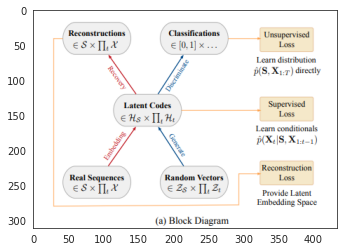

In [24]:
img = mpimg.imread('../../../../imgs/timegan_blocks.png')
imgplot = plt.imshow(img)
plt.show()

In [25]:
hidden_dim = 24 # number oof GRU units
num_layers = 3  # number of layers in an RNN

# logger 
writer = tf.summary.create_file_writer(log_dir.as_posix())

### 4.1. Input Place Holders

In [26]:
# Empty placeholder
X = Input(shape=[seq_len, n_seq], name="RealData")
Z = Input(shape=[seq_len, n_seq], name='RandomData')

### 4.2. Generic RNN Block
This is a building block for Generator, Discriminator, and Supervisor.

In [27]:
def make_rnn(n_layers, hidden_units, output_units, name):
    """Create an RNN with 3 hidden layer, each with 24 GRU units.
    
    @Parameters:
    n_layers = number of hidden layers.
    hidden_units = number of GRU units.
    output_units = output size.
    name = name of the architecture.
    
    @Return:
    Sequential model of the defined architecture.
    """
    return Sequential([GRU(units=hidden_units,
                          return_sequences=True,
                          name=f'GRU_{i + 1}') for i in range(n_layers)] + 
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

### 4.3. Embedder Function & Recovery Function of Autoencoder

In [28]:
embedder = make_rnn(n_layers=3,
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim,
                    name='Embedder')
recovery = make_rnn(n_layers=3,
                    hidden_units=hidden_dim,
                    output_units=n_seq,
                    name='Recovery')

### 4.4. Generator, Discriminator, & Supervisor
Noted that the supervisor only has 2 GRU units.

In [29]:
generator = make_rnn(n_layers=3,
                     hidden_units=hidden_dim,
                     output_units=hidden_dim,
                     name='Generator')

discriminator = make_rnn(n_layers=3,
                         hidden_units=hidden_dim,
                         output_units=1,
                         name='Discriminator')

supervisor = make_rnn(n_layers=2,
                      hidden_units=hidden_dim,
                      output_units=hidden_dim,
                      name='Supervisor')

## 5. TimeGAN Training Setup

There are three training phases:
- 1. Train an Autoencoder with real data (Embedding adn Recovery Functions). We want a very good-feature mapping function
- 2. Train a supervisor with real data. We want a model that learn the temporal dependency of time-series.
- 3. Jointly train all component with real and random data. We want a Generator that can generate real-synthetic data.

In [30]:
train_steps = 5 #10000
gamma = 1

In [31]:
# Loss functions
mse = MeanSquaredError()
bce = BinaryCrossentropy()

### 5.1 Autoencoder Training

The autoencoder has the embedder and recovery functions. We train the Autoencoder with real dataset. Here, Autoencoder acts as a feature-map function between low-level (24x24) and high-level dimension (24x26). This feature-map function takes in input data X, get it too latent-space, then generate back to high-level. The loss is between the original input data X with the output X_tilde from the Autoencoder.

In [32]:
# Architecture
H = embedder(X)                           # Output latent-space of embedding function
X_tilde = recovery(H)                     # Output high-level of recovery function

autoencoder = Model(inputs=X,             # Autoencoder as feature maps between low-level and high-level dimension
                    outputs=X_tilde,
                    name="Autoencoder")

In [33]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 26)]          0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            11544     
                                                                 
 Recovery (Sequential)       (None, 24, 26)            11450     
                                                                 
Total params: 22,994
Trainable params: 22,994
Non-trainable params: 0
_________________________________________________________________


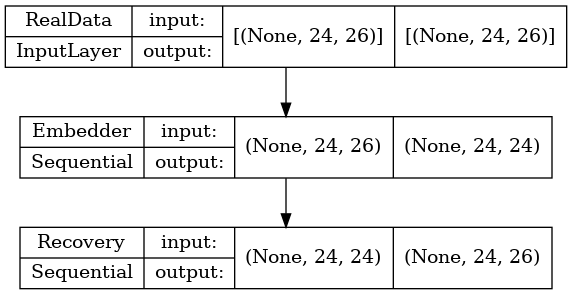

In [34]:
# Plot and save Autoencoder architecture
plot_model(autoencoder,
           to_file=('../../../../imgs/autoencoder_batadal.png'),
           show_shapes=True)

In [35]:
# Optimizer
autoencoder_optimizer = Adam()

In [36]:
# Training Step
@tf.function

def train_autoencoder_init(x):
    """Train the autoencoder
    @Parameters:
    x: input batch time-series
    
    @Return:
    loss
    """
    with tf.GradientTape() as tape:                # to update the training gradient
        x_tilde = autoencoder(x)                   # prediction of high-level to high-level (24,26) -> (24, 26)
        embedding_loss_t0 = mse(x, x_tilde)        # loss                                    
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0) # scale loss
    
    var_list = embedder.trainable_variables + recovery.trainable_variables # concetenate the training variables of both embedder and recovery function components
    gradients = tape.gradient(e_loss_0, var_list) # calculate loss with respect of both embedder and recovery
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list)) # keep track of the gradient
    return tf.sqrt(embedding_loss_t0)

In [37]:
# Reconstruct loss by comparing the autoencoder outputs with its input.
for step in tqdm(range(train_steps)):           # tqdm is a training bar
    X_ = next(real_series_iter)                 # get a random training batch (128, 24, 26)
    step_e_loss_t0 = train_autoencoder_init(X_) # train with a training batch
    with writer.as_default():                   # update the loss
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


### 5.2. Supervised Training

We train the supervisor "supervised learning" with real dataset. The Supervisor model basically make sure that the latent-space data has temporal-dependency of the real-data. The loss compares the output of the supervisor with the next timestep for the embedded sequence. This is important for the model to learn the temporal dependency.

In [38]:
# Optimizer for a supervised learning model
supervisor_optimizer = Adam()

In [39]:
# Training Steps
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:                # to update the training gradient
        h = embedder(x)                            # output latent-space of embedding function                           
        h_hat_supervised = supervisor(h)           # output high-level
        # loss compares the output of the supervisor with the next timestep for the embedded sequence. This is important for the model to learn the temporal dependency.
        g_loss_s = mse(h[:, 1: , :], h_hat_supervised[:, :-1, :])
        
    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list) # calculate loss with respect of supervisor
    supervisor_optimizer.apply_gradients(zip(gradients, var_list)) # keep track of the gradient
    return g_loss_s

In [40]:
# Reconstruct loss by comparing the supervisor outputs with its input.
for step in tqdm(range(train_steps)):          # tqdm is a training bar
    X_ = next(real_series_iter)                # get a random training batch (128, 24, 26)
    step_g_loss_s = train_supervisor(X_)       # train with a training batch
    with writer.as_default():                  # update the loss
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


### 5.3. Joint Training 

This training phase using all 4 time-gan components. We will use multiple loss functions and components to achieve simultaneous learning of latent space embedding, transition dynamics, and synthetic data generation.

### Synthetic Data Generator (Data > Generator > Trained Supervisor > Discriminator (binary))

In [41]:
# Adversarial Architectture - Supervised
E_hat = generator(Z)                     # Generate high-level data to low-level latent-space (un-trained generator)
H_hat = supervisor(E_hat)                # Fetch the low-level to trained supervisor to keep temporal dependence.
Y_fake = discriminator(H_hat)            # Generate from low-level to high-level synthetic data.

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [42]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 26)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            11544     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 30,169
Trainable params: 30,169
Non-trainable params: 0
_________________________________________________________________


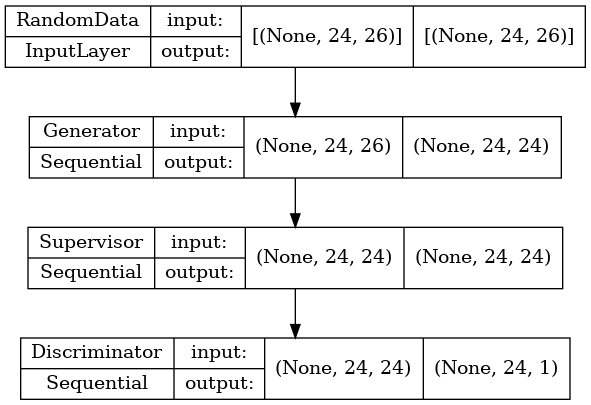

In [43]:
# Plot and save Generator model.
plot_model(adversarial_supervised, 
            to_file=('../../../../imgs/generator_batadal.png'),
           show_shapes=True)

### Synthetic Data Generator (Data > Generator > Discriminator (binary))

In [44]:
# Adversarial Architecture in Latent Space
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [45]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 26)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            11544     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 22,369
Trainable params: 22,369
Non-trainable params: 0
_________________________________________________________________


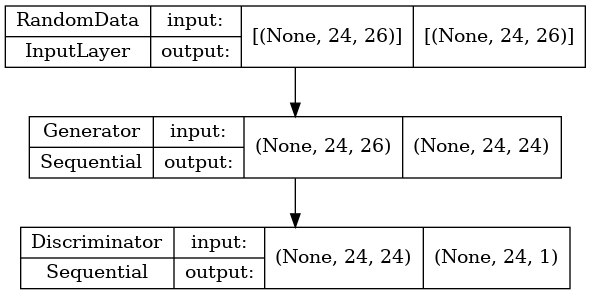

In [46]:
# Plot and save embedder model
plot_model(adversarial_emb, 
           to_file=('../../../../imgs/adversarial_emb_batadal.png'),
           show_shapes=True)

### Synthetic Data Generator (Data > Generator > Supervisor > Discriminator (input-size))

In [47]:
# Mean & Variance Loss
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [48]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 26)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            11544     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 26)            11450     
                                                                 
Total params: 30,794
Trainable params: 30,794
Non-trainable params: 0
_________________________________________________________________


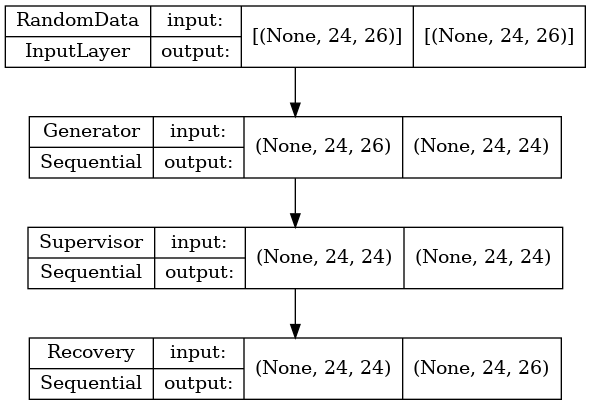

In [49]:
# Plot and save synthetic data generator model.
plot_model(synthetic_data, 
           to_file=('../../../../imgs/synthetic_batadal.png'),
           show_shapes=True)

In [50]:
def get_generator_moment_loss(y_true, y_pred):
    """Generate and penalized synthetic data generator loss if the synthetic data deviate from the real data
    @Parameters:
    y_true: label
    y_pred: prediction
    
    @Return:
    generator's loss mean and variance.
    """
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

### Synthetic Data Generator (Data > Embedder > Discriminator (binary))

In [51]:
# Architecture for Discriminator
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [52]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 26)]          0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            11544     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 22,369
Trainable params: 22,369
Non-trainable params: 0
_________________________________________________________________


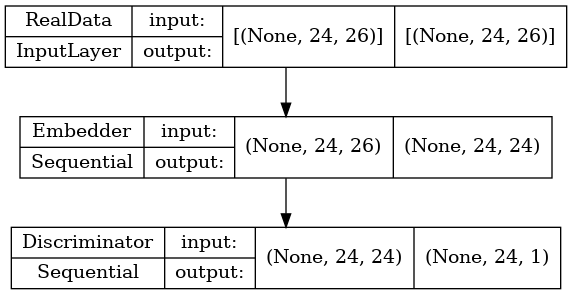

In [53]:
# Plot and save discriminator
plot_model(discriminator_model, 
           to_file=('../../../../imgs/discriminator_batadal.png'),
           show_shapes=True)

### Optimizers

In [54]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## 6. Training Steps

### 6.1. Generator
Goal is to get a really good generator by keeping as much information as possible.

In [55]:
@tf.function
def train_generator(x, z):
    """Generates 4 loss functions of the combined TimeGAN components.
    """
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)                                        # (data > generator > trained supervisor > binary discriminator)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),            # unsupervised loss 1 (not supervised cuz the label is not time series)
                                          y_pred=y_fake)                          # loss between synthetic or real data

        y_fake_e = adversarial_emb(z)                                             # (data > generator > binary discriminator)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),        # unsupervised loss 2 (not supervised cuz the label is not time series)
                                            y_pred=y_fake_e)                      # loss between synthetic or real data
        h = embedder(x)                                                           # output latent-space embedder
        h_hat_supervised = supervisor(h)                                          # (data > generator >supervisor > discriminator)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])  # supervised loss 1. Loss between generate time-series to next real time-series

        x_hat = synthetic_data(z)                                                 # (data > latent-space embedder > binary discriminator)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)               # moment-loss. loss between synthetic or real data

        generator_loss = (generator_loss_unsupervised +                           # concate all losses for generator
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables # update the gradient of both generator and supervisor (temporal preservation)
    gradients = tape.gradient(generator_loss, var_list) # calculate loss with respect of generator and supervisor
    generator_optimizer.apply_gradients(zip(gradients, var_list)) # keep track of the gradient
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

### 6.2. Embedding 

In [56]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape: 
        h = embedder(x)                                                            # output latent-space embedder
        h_hat_supervised = supervisor(h)                                           # time-series in latent-space - label since supervisor is trained
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])   # loss between the current latent-space time series with label latent-space time series

        x_tilde = autoencoder(x)                                                   # output feature-map
        embedding_loss_t0 = mse(x, x_tilde)                                        # same loss of the autoencoder
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised # concatenate embedding and generator loss

    var_list = embedder.trainable_variables + recovery.trainable_variables # update the gradient of autoencoder
    gradients = tape.gradient(e_loss, var_list) # calculate loss with respect of autoencoder
    embedding_optimizer.apply_gradients(zip(gradients, var_list)) # keep track of the gradient
    return tf.sqrt(embedding_loss_t0)

### 6.3. Discriminator

In [57]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)                                 # output binary
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),      # loss between labeled real or synthetic data
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)                              # (data > generator > trained supervisor > binary discriminator)  
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),     # unsupervised loss 1 (not supervised cuz the label is not time series)
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)                                   # (data > generator > binary discriminator)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e), # unsupervised loss 2 (not supervised cuz the label is not time series)
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +                               # concatenate the loss
            discriminator_loss_fake + 
            gamma * discriminator_loss_fake_e)

In [58]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)           

    var_list = discriminator.trainable_variables # update the gradient of discriminator
    gradients = tape.gradient(discriminator_loss, var_list) # calculate loss with respect of discriminator
    discriminator_optimizer.apply_gradients(zip(gradients, var_list)) # keep track of the gradient
    return discriminator_loss

### 6.4. Final Training Loop

In [59]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.0368 | g_loss_u: 0.7368 | g_loss_s: 0.0029 | g_loss_v: 0.3533 | e_loss_t0: 0.3061


## 7. Log Synthetic Data Generator

Save generated synthetic data locally.

In [60]:
synthetic_data.save(log_dir / 'synthetic_data_batadal')

2022-05-01 23:16:47.830098: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../results/experiment_00/synthetic_data_batadal/assets


INFO:tensorflow:Assets written to: ../../results/experiment_00/synthetic_data_batadal/assets


## 8. Generate Synthetic Time-Series Data

In [61]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [62]:
len(generated_data)

68

In [63]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(8704, 24, 26)

In [64]:
np.save(log_dir / 'generated_data_batadal.npy', generated_data)

### 8.1. Rescale
Rescale with MinMaxScaler to compare with the original dataset

In [65]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(8704, 24, 26)

### 8.2. Plot Sample Series
Plot and compare between the original and synthetic data.

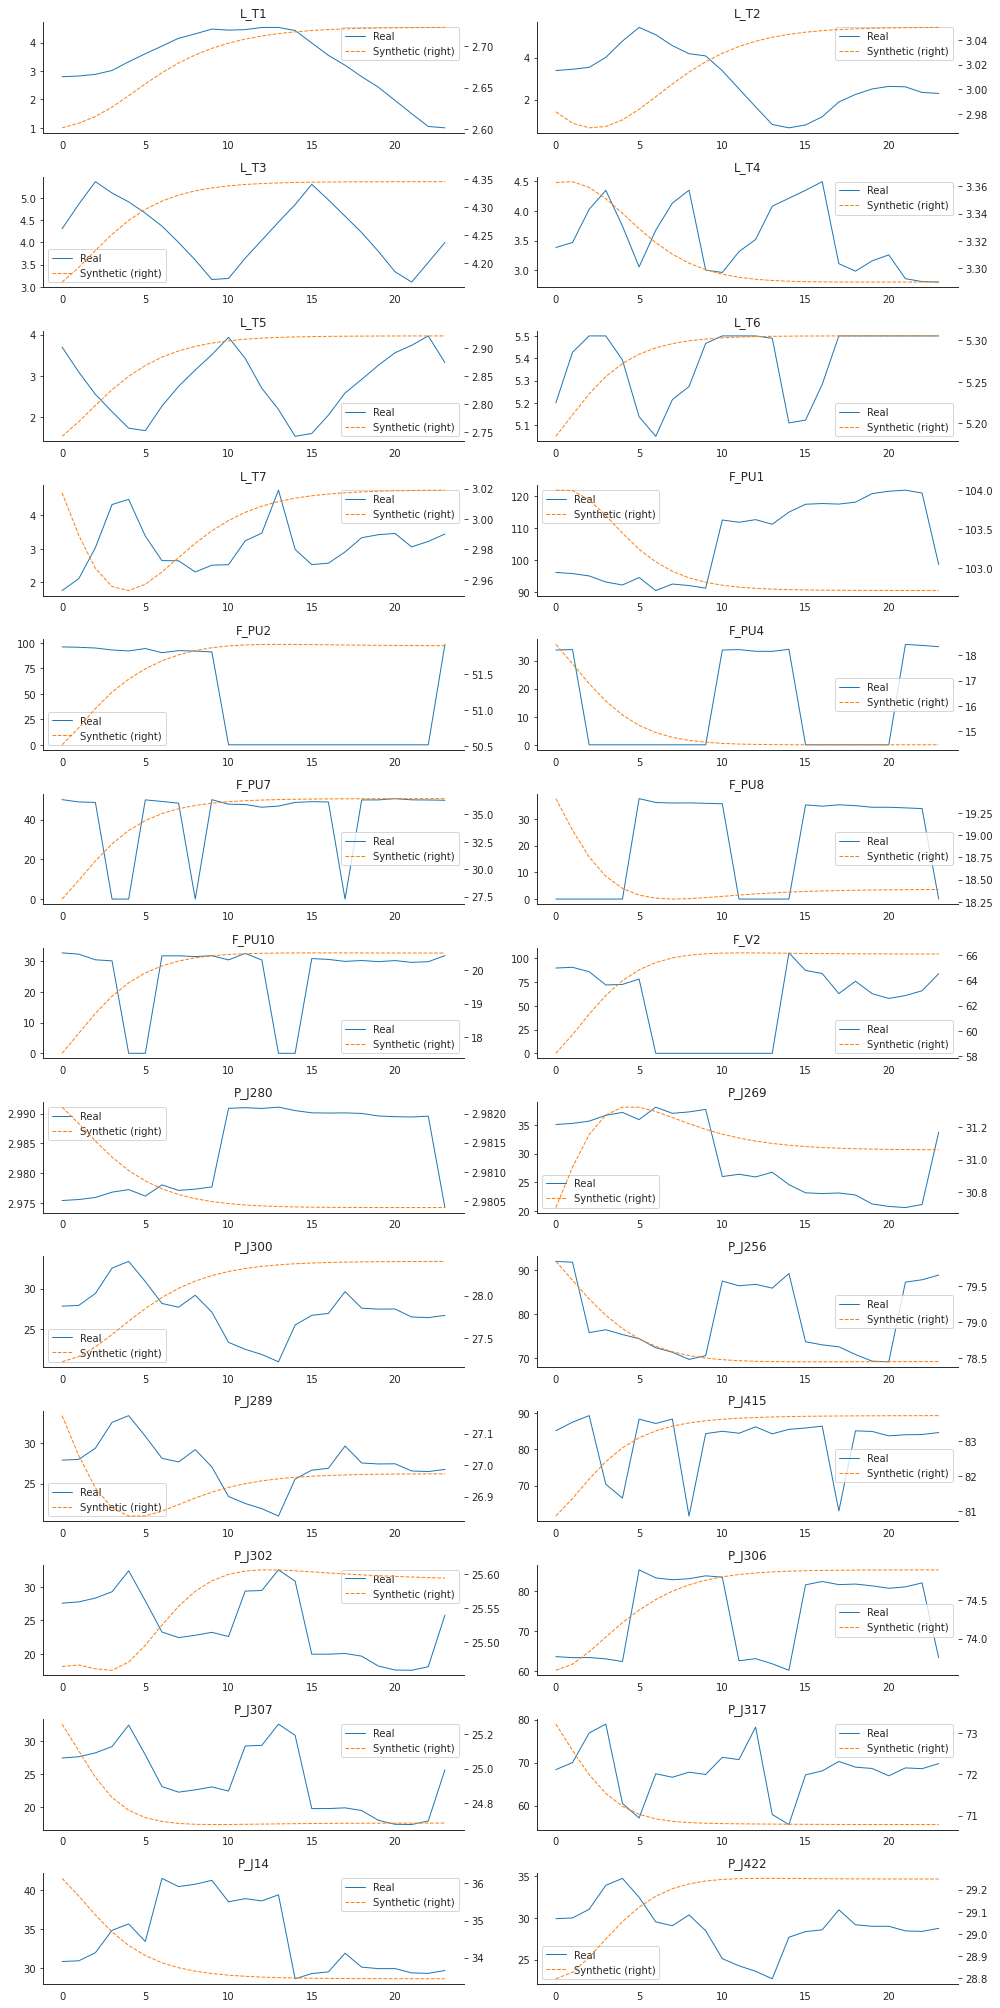

In [66]:
fig, axes = plt.subplots(nrows=13, ncols=2, figsize=(14, 28))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(features):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()